In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import optuna
import numpy as np

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 
data = df.iloc[:,:-1]

In [19]:
df.shape

(5656, 16)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   meanR   5656 non-null   float64
 1   meanG   5656 non-null   float64
 2   meanB   5656 non-null   float64
 3   stdR    5656 non-null   float64
 4   stdG    5656 non-null   float64
 5   stdB    5656 non-null   float64
 6   skewR   5656 non-null   float64
 7   skewG   5656 non-null   float64
 8   skewB   5656 non-null   float64
 9   kurR    5656 non-null   float64
 10  kurG    5656 non-null   float64
 11  kurB    5656 non-null   float64
 12  entR    5656 non-null   float64
 13  entG    5656 non-null   float64
 14  entB    5656 non-null   float64
dtypes: float64(15)
memory usage: 662.9 KB


###Preprocessing

In [4]:
#Standarization
scaler = StandardScaler()

df_scaled = scaler.fit_transform(data.copy())
df_scaled = pd.DataFrame(df_scaled, columns=data.columns)

df_scaled.head(3)

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB
0,-0.665102,0.008693,-0.644699,-0.957046,-0.074790,-0.358296,-0.280260,-0.336533,0.694148,-0.275050,-0.357389,0.413462,0.260530,0.270445,-1.030791
1,-0.731039,-0.226412,-0.811958,-0.894219,-0.183617,-0.720664,0.071609,0.002909,0.695626,0.022708,-0.088418,0.532731,-0.107272,-0.118157,-1.012572
2,-0.178144,-0.392545,-0.305512,-0.087327,-0.407671,-0.370002,0.016748,0.039301,0.182180,-0.090864,-0.068511,0.161766,-0.205810,-0.210945,0.042868


In [5]:
#Split Dataset
X = df_scaled
y = df['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y_train.unique()


array([5, 4, 2, 1, 6, 3])

###Dimension Reduction

In [7]:
#Dimension Reduction PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [8]:
def plot_dimension(data):
    plt.figure(figsize=(16, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=y_train, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(1, 7), label='Class')
    plt.title("Visualization of Classes")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

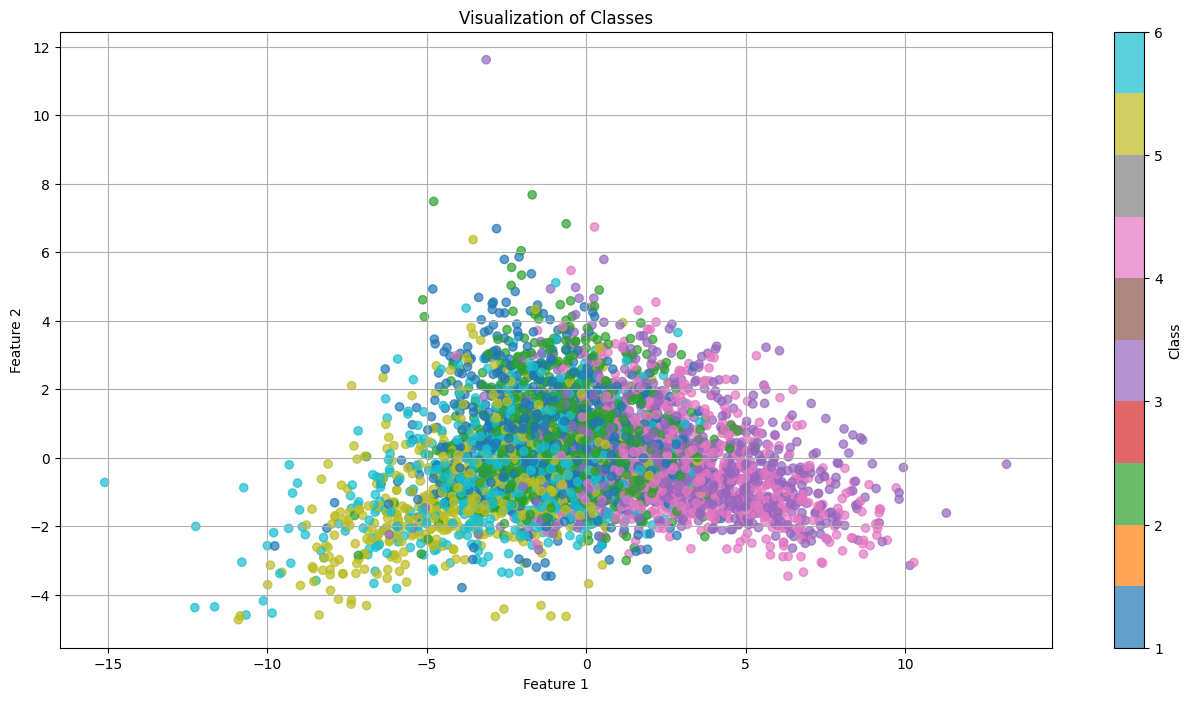

In [9]:
plot_dimension(X_pca)

###Building Model

In [10]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)
            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

In [11]:
# Dengan PCA
m = 10      
fitur = 2
R = 4  
alpha0 = 0.11910072554906094          
tau = 584             
n_iterations = 930  

# Initialize the SOM
som_pca = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

# Train the SOM with the PCA-reduced dataset
som_pca.train(X_pca, n_iterations)

# After training, you can access the SOM weights with:
weights_pca = som_pca.w
print("Trained SOM weights:", weights_pca)

Trained SOM weights: [[ 5.74688486 -0.86167561]
 [ 3.87437064 -0.2114685 ]
 [ 2.20169102 -0.43455772]
 [ 1.03489654 -0.16939854]
 [ 0.46435534  0.88989656]
 [-0.93938923  1.88039381]
 [-2.1854212   1.13143872]
 [-1.95701577 -0.07013481]
 [-3.31323306 -0.92906869]
 [-4.93992245 -1.35811774]]


C:\Users\lmaos\AppData\Local\Temp\ipykernel_24324\2220835867.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  # Colormap 'tab10' untuk warna berbeda


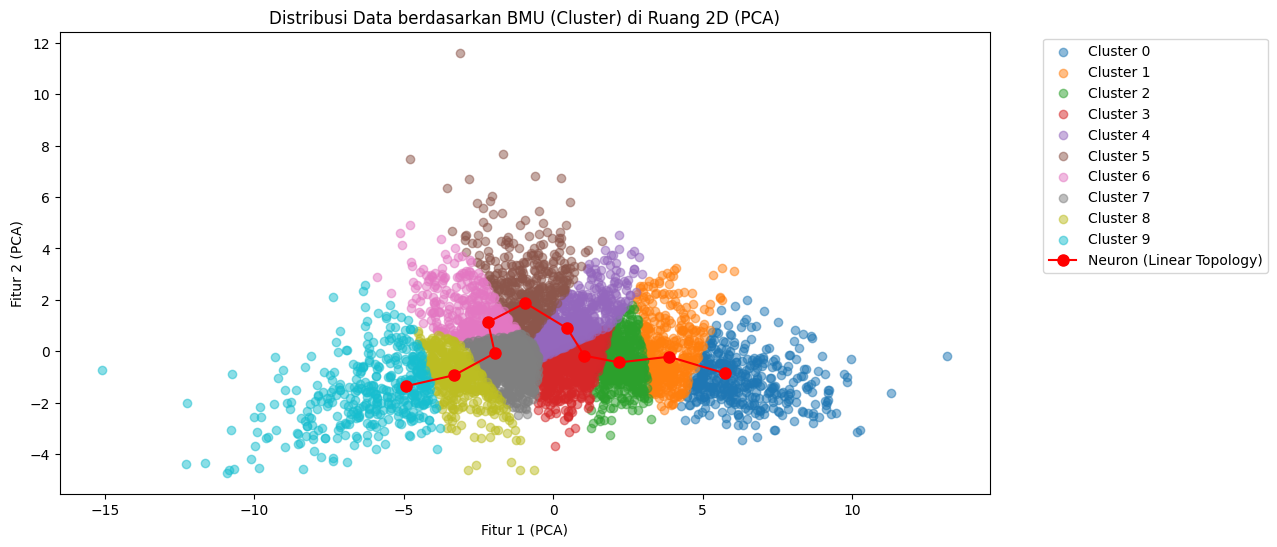

In [12]:
# Melakukan PCA ke 2D untuk visualisasi
from sklearn.decomposition import PCA

# Asumsi Anda sudah memiliki X_train sebagai data asli tanpa kelas (tanpa kolom 'Class')
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca)

# Hitung BMU untuk setiap titik data dalam hasil PCA
bmu_indices_pca = np.array([som_pca.hitung_bmu(x) for x in X_pca_2d])

# Buat scatter plot dengan warna berbeda untuk setiap BMU berdasarkan hasil PCA
plt.figure(figsize=(12, 6))

# Loop untuk setiap BMU unik
unique_bmu_indices_pca = np.unique(bmu_indices_pca)
colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  # Colormap 'tab10' untuk warna berbeda

for i, bmu in enumerate(unique_bmu_indices_pca):
    # Filter data yang termasuk dalam BMU saat ini
    cluster_data_pca = X_pca_2d[bmu_indices_pca == bmu]
    plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], label=f'Cluster {bmu}', color=colors(i), alpha=0.5)

# Plot neuron dalam topologi linier untuk PCA sebagai titik merah
plt.plot(weights_pca[:, 0], weights_pca[:, 1], 'r-o', label="Neuron (Linear Topology)", markersize=8)

plt.title("Distribusi Data berdasarkan BMU (Cluster) di Ruang 2D (PCA)")
plt.xlabel("Fitur 1 (PCA)")
plt.ylabel("Fitur 2 (PCA)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

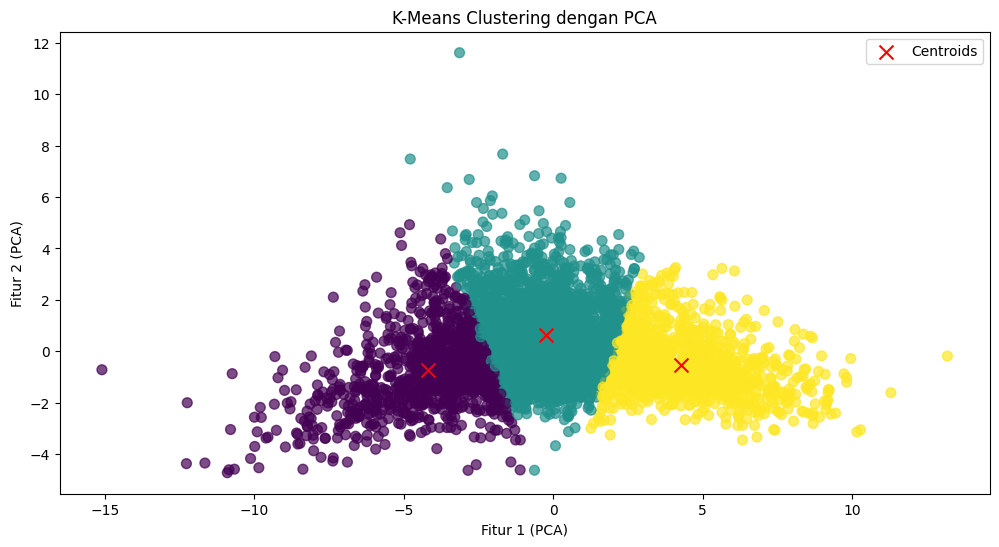

Silhouette Score untuk K-Means: 0.39


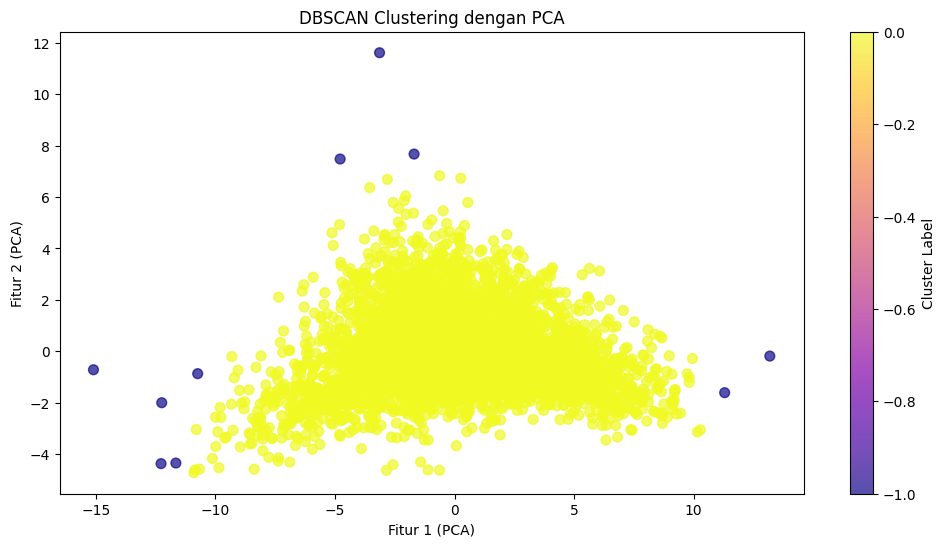

Jumlah Cluster yang Ditemukan oleh DBSCAN: 1
Jumlah Data Noise (Outlier): 10


In [13]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Tentukan jumlah cluster (misalnya 3)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualisasi K-Means Clustering
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("K-Means Clustering dengan PCA")
plt.xlabel("Fitur 1 (PCA)")
plt.ylabel("Fitur 2 (PCA)")
plt.legend()
plt.show()

# Evaluasi K-Means dengan Silhouette Score
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
print(f"Silhouette Score untuk K-Means: {kmeans_silhouette:.2f}")

# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=10)  # Atur parameter eps dan min_samples sesuai dataset
dbscan_labels = dbscan.fit_predict(X_pca)

# Visualisasi DBSCAN Clustering
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', s=50, alpha=0.7)
plt.title("DBSCAN Clustering dengan PCA")
plt.xlabel("Fitur 1 (PCA)")
plt.ylabel("Fitur 2 (PCA)")
plt.colorbar(label="Cluster Label")
plt.show()

# Evaluasi DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Hitung jumlah cluster tanpa noise (-1)
print(f"Jumlah Cluster yang Ditemukan oleh DBSCAN: {n_clusters_dbscan}")
print(f"Jumlah Data Noise (Outlier): {sum(dbscan_labels == -1)}")


In [13]:
len(unique_bmu_indices_pca)

10

In [14]:
for bmu in unique_bmu_indices_pca:
    cluster_data = X_pca_2d[bmu_indices_pca == bmu]
    print(f"Cluster {bmu}: {len(cluster_data)} data")


Cluster 0: 394 data
Cluster 1: 518 data
Cluster 2: 522 data
Cluster 3: 620 data
Cluster 4: 490 data
Cluster 5: 285 data
Cluster 6: 413 data
Cluster 7: 596 data
Cluster 8: 384 data
Cluster 9: 302 data


In [15]:
for bmu in unique_bmu_indices_pca:
    cluster_data = X_pca[bmu_indices_pca == bmu]
    print(f"Cluster {bmu} - Mean Features:")
    print(cluster_data.mean(axis=0))


Cluster 0 - Mean Features:
[ 6.37151764 -1.11587553]
Cluster 1 - Mean Features:
[ 3.6202076  -0.31703531]
Cluster 2 - Mean Features:
[1.97809258 0.29816221]
Cluster 3 - Mean Features:
[ 0.34780444 -0.6888055 ]
Cluster 4 - Mean Features:
[0.33171953 1.63818514]
Cluster 5 - Mean Features:
[-1.6953473   3.18758939]
Cluster 6 - Mean Features:
[-2.40528313  1.05782035]
Cluster 7 - Mean Features:
[-1.55263353 -0.71633652]
Cluster 8 - Mean Features:
[-3.69797425 -0.85889076]
Cluster 9 - Mean Features:
[-6.53789247 -1.70862547]


In [16]:
# Konversi y_train_np menjadi tipe integer
y_train_np = y_train.astype(int)

# Loop untuk menghitung distribusi kelas dalam setiap cluster
for bmu in unique_bmu_indices_pca:
    # Filter data berdasarkan BMU
    cluster_classes = y_train_np[bmu_indices_pca == bmu]
    print(f"Cluster {bmu} - Class Distribution:")
    print(np.bincount(cluster_classes))


Cluster 0 - Class Distribution:
[  0   0   1 217 176]
Cluster 1 - Class Distribution:
[  0  16  37 231 216   4  14]
Cluster 2 - Class Distribution:
[  0  88 105 114 167  18  30]
Cluster 3 - Class Distribution:
[  0 133 155  69  99  56 108]
Cluster 4 - Class Distribution:
[  0 122 154  58  78  29  49]
Cluster 5 - Class Distribution:
[  0 108  96  20  17  18  26]
Cluster 6 - Class Distribution:
[  0 154 110  13   1  58  77]
Cluster 7 - Class Distribution:
[  0 144 148  31  17 108 148]
Cluster 8 - Class Distribution:
[  0  69  52   9   1 122 131]
Cluster 9 - Class Distribution:
[  0  21   8   3   0 168 102]


In [31]:
unique_classes = np.unique(y_train_np)
print("Kelas unik:", unique_classes)


Kelas unik: [1 2 3 4 5 6]


In [34]:
print("Jumlah BMU unik:", len(np.unique(bmu_indices_pca)))


Jumlah BMU unik: 10


In [33]:
print("Kelas unik di y_train_np:", np.unique(y_train_np))


Kelas unik di y_train_np: [1 2 3 4 5 6]


In [36]:
unique_bmu_indices = np.unique(bmu_indices_pca)
colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices))


C:\Users\lmaos\AppData\Local\Temp\ipykernel_18036\3792393036.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices))


In [32]:
from collections import Counter
print("Distribusi Kelas di y_train:", Counter(y_train_np))


Distribusi Kelas di y_train: Counter({2: 866, 1: 855, 4: 772, 3: 765, 6: 685, 5: 581})


In [83]:
def calculate_qe_per_data(som, data):
    qe_per_data = []
    for x in data:
        bmu_index = som.hitung_bmu(x)
        qe = np.linalg.norm(x - som.w[bmu_index])
        qe_per_data.append(qe)
    return np.array(qe_per_data)

# Hitung QE untuk data
qe_per_data = calculate_qe_per_data(som_pca, X_pca)


In [84]:
threshold = np.percentile(qe_per_data, 95)  # Misalnya, persentil ke-95
outliers = X_pca[qe_per_data > threshold]

print(f"Jumlah Outlier: {len(outliers)}")


Jumlah Outlier: 227


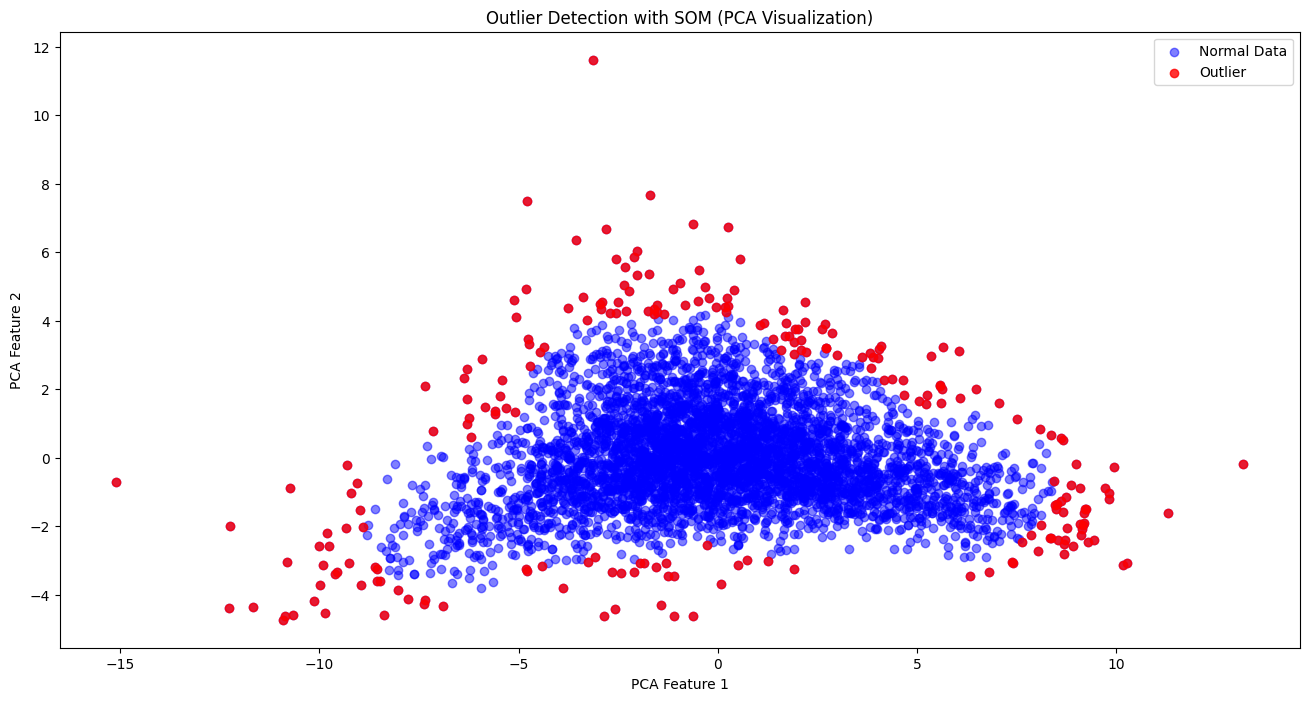

In [85]:
plt.figure(figsize=(16, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', label="Normal Data", alpha=0.5)
plt.scatter(X_pca[qe_per_data > threshold, 0], X_pca[qe_per_data > threshold, 1], c='red', label="Outlier", alpha=0.8)
plt.legend()
plt.title("Outlier Detection with SOM (PCA Visualization)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()


###Evaluasi 1

In [86]:
qe = som_pca.quantization_error(X_pca)
te = som_pca.topographic_error(X_pca)

print("Quantization Error (QE):", qe)
print("Topographic Error (TE):", te)

Quantization Error (QE): 1.0697769128178791
Topographic Error (TE): 0.21794871794871795


In [87]:
from sklearn.metrics import silhouette_score
# Hitung Silhouette Score dengan label yang sesuai
silhouette_avg = silhouette_score(X_pca, y_train.values)  # Gunakan y_train untuk mencocokkan data pada X_pca
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.08070095881673511


In [ ]:
map_size = (6, 1)  # 6 neurons in 1 row (linear SOM)

weights_pca = som_pca.w  # weights_pca seharusnya berbentuk (6, 1)

# Hitung beberapa metrik menggunakan somperf
print('Topographic Product =', topographic_product(rectangular_topology_dist(map_size), weights_pca))
print('Neighborhood Preservation =', neighborhood_preservation(1, weights_pca, X_pca))
print('Trustworthiness =', trustworthiness(1, weights_pca, X_pca))

Topographic Product = -0.007596293310410708
Neighborhood Preservation = -1.3795012769871318


###Tuning

In [ ]:
# import optuna
# import numpy as np
# from sklearn.metrics import silhouette_score

# # Pastikan class SOMlinier sudah didefinisikan sebelumnya dengan metode quantization_error() dan topographic_error()

# # Fungsi objektif untuk optimasi Optuna
# def objective(trial):
#     # Tuning parameter
#     m = trial.suggest_int('m', 5, 20)           # Jumlah neuron
#     R = trial.suggest_int('R', 1, 5)            # Radius
#     alpha0 = trial.suggest_float('alpha0', 0.01, 0.5)  # Learning rate
#     tau = trial.suggest_int('tau', 100, 1000)   # Konstanta peluruhan
#     n_iterations = trial.suggest_int('n_iterations', 500, 2000)  # Iterasi pelatihan
    
#     # Inisialisasi dan latih SOM dengan parameter yang dipilih
#     som = SOMlinier(m=m, fitur=X_train_np.shape[1], R=R, alpha=alpha0, tau=tau)
#     som.train(X_train_np, n_iterations)

#     # Hitung QE, TE, dan Silhouette Score
#     qe = som.quantization_error(X_train_np)
#     te = som.topographic_error(X_train_np)

#     # Hitung BMU untuk setiap data dan hitung Silhouette Score
#     bmu_indices = np.array([som.hitung_bmu(x) for x in X_train_np])
#     silhouette = silhouette_score(X_train_np, bmu_indices)
    
#     # Kombinasikan ketiga metrik dengan bobot tertentu
#     # Di sini, kita meminimalkan QE dan TE, tetapi memaksimalkan Silhouette Score
#     # Jadi kita gunakan negatif Silhouette Score (karena Optuna meminimalkan nilai)
#     combined_score = (0.4 * qe) + (0.4 * te) - (0.2 * silhouette)

#     return combined_score

# # Buat study untuk optimasi
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# # Cetak hasil terbaik
# print("Best parameters for SOM:", study.best_params)
# print("Best combined score:", study.best_value)
